# 使用OSMnx拓扑校正和简化街道网络

In [1]:
import osmnx as ox
import networkx as nx
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11dev'

# 创建一个街道路网并简化它

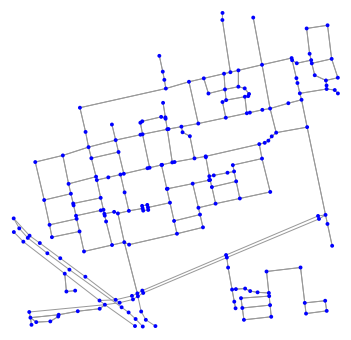

In [2]:
# 通过一个经纬度点来创建周围网络，并展示
location_point = (39.9502417, 116.3370525)  # 北京交通大学
G = ox.graph_from_point(location_point, distance=500, simplify=False)
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3)

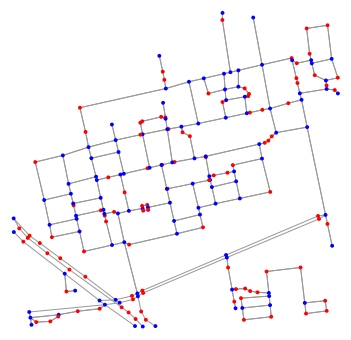

In [3]:
# 展示哪些点我们需要移除，如果我们想简化它
nc = ['b' if ox.is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)

In [4]:
# 简化路网
G2 = G.copy()
G2 = ox.simplify_graph(G2)

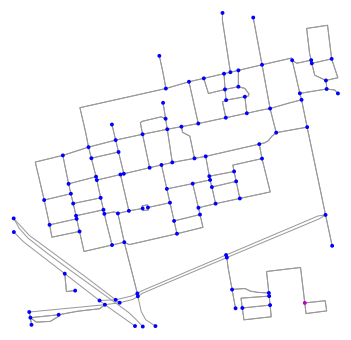

In [5]:
# 绘制简化后的路网，并用洋红色显示存在的回路
loops = [edge[0] for edge in nx.selfloop_edges(G2)]
nc = ['m' if node in loops else 'b' for node in G2.nodes()]
fig, ax = ox.plot_graph(G2, node_color=nc, node_zorder=3)

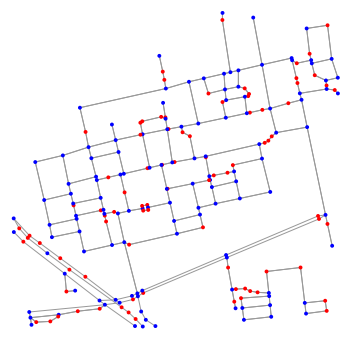

In [6]:
# 关闭strict ，查看需要删除的点
nc = ['b' if ox.is_endpoint(G, node, strict=False) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)

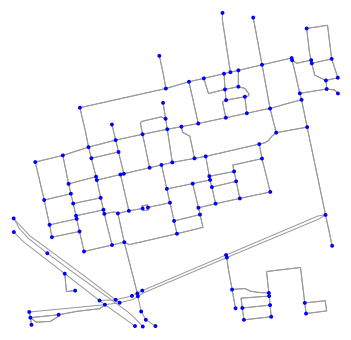

In [7]:
# 非严格条件下，简化路网
G3 = G.copy()
G3 = ox.simplify_graph(G3, strict=False)
fig, ax = ox.plot_graph(G3, node_color='b', node_zorder=3)

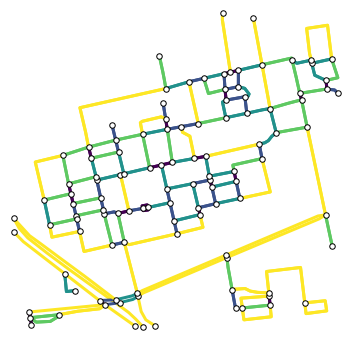

In [8]:
# 显示执行严格简化的网络，并根据网络长度进行着色
ec = ox.get_edge_colors_by_attr(G2, attr='length')
fig, ax = ox.plot_graph(G2, node_color='w', node_edgecolor='k', node_size=30, node_zorder=3, edge_color=ec, edge_linewidth=3)

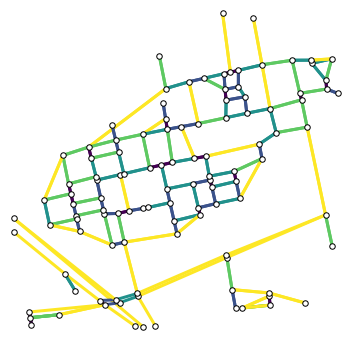

In [9]:
# 绘制相同的网络 （拓扑同构），这次忽略了边缘的空间几何形状
ec = ox.get_edge_colors_by_attr(G2, attr='length')
fig, ax = ox.plot_graph(G2, node_color='w', node_edgecolor='k', node_size=30, node_zorder=3, 
                           edge_color=ec, edge_linewidth=3, edge_alpha=1, use_geom=False)

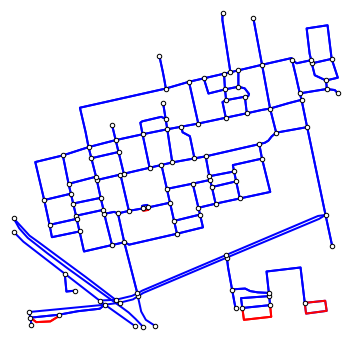

In [10]:
# 高亮平行边
ec = ['b' if key == 0 else 'r' for u, v, key in G2.edges(keys=True)]
fig, ax = ox.plot_graph(G2, node_color='w', node_edgecolor='k', node_size=20, node_zorder=3, edge_color=ec, edge_linewidth=2)

# 清理网络边缘

这与简化有关。默认情况下，OSMnx（干净的外围参数等于True）会将您请求的区域缓冲0.5公里，然后在此较大的缓冲区域中检索街道网络。然后，它简化了拓扑，使节点代表街道的交叉点（而不是包括所有的非页内OSM节点）。然后，它计算此较大网络中每个节点的（无向）度。接下来，它会根据您请求的实际区域（通过边界框或多边形）来截断该网络。最后，它将节点度值的字典另存为图形属性。

这有两个主要好处。首先，它清除了周围杂散的假边缘。如果clean_periphery = False，则请求区域内的外围非相交节点似乎是死路，因为导致该区域外相交的边的其余部分将被忽略。如果clean_periphery = True，则首先创建较大的图，从而将这些边简化为它们的真实相交，从而在将其截断到实际请求的区域后将其整体修剪。其次，它通过以下两种方式提供了准确的节点度数：a）计算节点邻居，即使它们不在保留的网络范围内（因此您也不会要求4度）
节点为2级，因为它的邻居中只有2个位于该区域内），并且b）不将所有那些杂散的虚假边缘的末端节点都计为cul-de-sac，否则将严重增加degree= 1的节点的数量，甚至尽管这些节点实际上只是交叉路口之间切碎的街道段中间的插页式节点。

In [11]:
# 获取边界
bbox = ox.bbox_from_point((45.518698, -122.679964), distance=300)
north, south, east, west = bbox

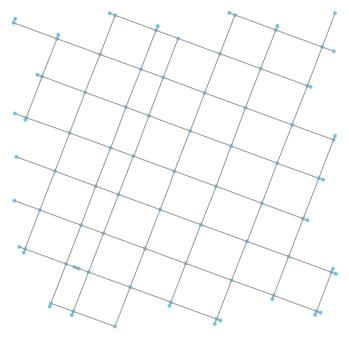

In [12]:
G = ox.graph_from_bbox(north, south, east, west, network_type='drive', clean_periphery=False)
fig, ax = ox.plot_graph(ox.project_graph(G))

In [13]:
# 这个网络图分布许多死路
k = dict(G.degree())
{n:list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 29, 2: 2, 3: 7, 4: 52}

在上方，注意所有外围杂散边缘存根。在下面，请注意，这些已清理，并且节点度相对于可能超出请求区域限制的较宽街道网络而言是准确的。

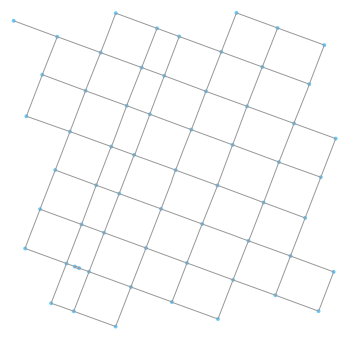

In [14]:
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
fig, ax = ox.plot_graph(ox.project_graph(G))

In [15]:
# the streets_per_node distribution for this cleaned up graph is more accurate   清理后的路网更加准确
# dict keys = count of streets emanating from the node (ie, intersections and dead-ends)  
# dict vals = number of nodes with that count
k = G.graph['streets_per_node']
{n:list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 0, 2: 0, 3: 3, 4: 58}

最后一个例子。将下面的网络与上一节中的网络进行比较。清理了杂散的外围边缘。另请注意，在左下角，两条插页节点保留在该东西街道上。为什么？这些实际上是交叉点，但是它们的（向南）边被删除了，因为这些边
下一个十字路口位于请求区域边界的南部。但是，OSMnx正确地将这些节点保留在图中，因为它们实际上是交叉点，应在交叉点密度的度量等中进行计数。

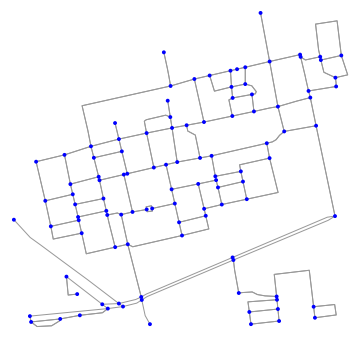

In [16]:
location_point = (39.9502417, 116.3370525)
G = ox.graph_from_point(location_point, distance=500, simplify=True)
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3)

# 为市中心创建一个机动车可达（drivable）网络，并简化它

In [17]:
location_point = (39.1235635, 117.1980785) # 天津市中心
G = ox.graph_from_point(location_point, distance=1500, network_type='drive', simplify=False)

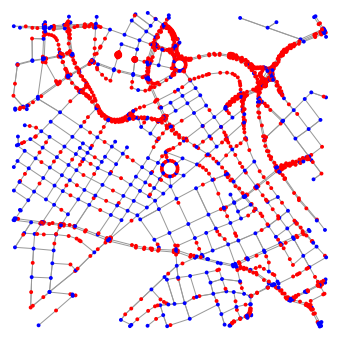

In [18]:
nc = ['b' if ox.is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)

In [19]:
G2 = G.copy()
G2 = ox.simplify_graph(G2)

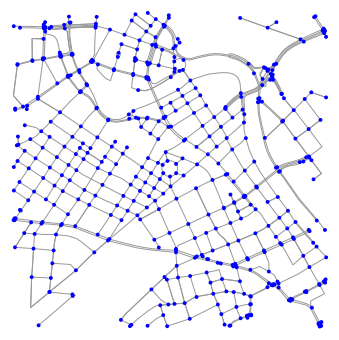

In [20]:
loops = [edge[0] for edge in nx.selfloop_edges(G2)]
nc = ['m' if node in loops else 'b' for node in G2.nodes()]
fig, ax = ox.plot_graph(G2, node_color=nc, node_zorder=3)

In [21]:
# 创建一个郊区路网，并简化他
G = ox.graph_from_address('Huilongguan,Beijing, China', 
                             distance=1000, network_type='drive', simplify=False)

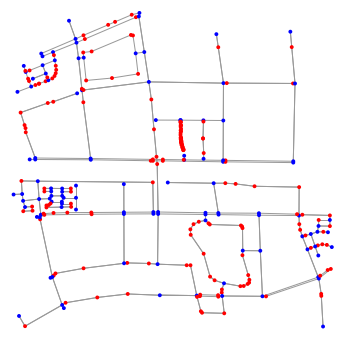

In [22]:
nc = ['b' if ox.is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)


In [23]:
G2 = G.copy()
G2 = ox.simplify_graph(G2)

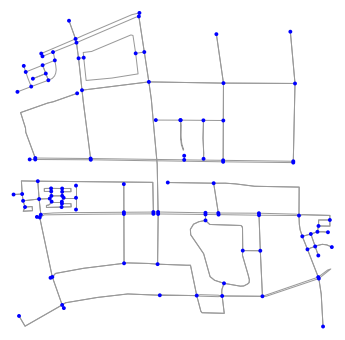

In [24]:
fig, ax = ox.plot_graph(G2, node_color='b', node_zorder=3)

In [25]:
# 保存成shp文件
ox.save_graph_shapefile(G2, filename='Huilongguan')

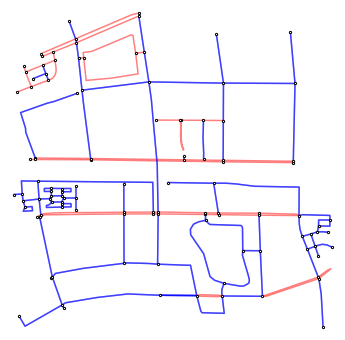

In [26]:
# highlight 单向道路
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G2.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G2, node_color='w', node_edgecolor='k', node_size=5, node_zorder=3, 
                           edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)